In [ ]:
# START REMOVE

In [1]:
# This is to use the sonarQube API
! pip install  --upgrade python-sonarqube-api

     |████████████████████████████████| 71kB 1.6MB/s eta 0:00:01


In [2]:
# This is to use the Gitlab API
!pip install python-gitlab

     |████████████████████████████████| 102kB 639kB/s ta 0:00:01


In [3]:
# This is for the templating engine
! pip install mako

     |████████████████████████████████| 81kB 4.2MB/s eta 0:00:011


In [7]:
# This is to use the dotenv to read ENV variables from .env files
!pip install python-dotenv

In [4]:
# This will be very useful later when you have to create a requirements.txt file
! pip list

Package                            Version  
---------------------------------- ---------
absl-py                            0.9.0    
alabaster                          0.7.12   
anaconda-client                    1.7.2    
anaconda-navigator                 1.9.12   
anaconda-project                   0.8.3    
appdirs                            1.4.4    
appnope                            0.1.0    
appscript                          1.0.1    
asn1crypto                         1.0.1    
astor                              0.8.0    
astroid                            2.3.1    
astropy                            3.2.2    
atomicwrites                       1.3.0    
attrs                              19.2.0   
awscli                             1.16.309 
azure-ai-textanalytics             5.0.0    
azure-common                       1.1.26   
azure-core                         1.9.0    
Babel                              2.7.0    
backcall                           0.1.0    
backports.

In [11]:
# This is to read environment variables (esp API tokens) from .env file
%reload_ext dotenv
%dotenv

In [12]:
# END REMOVE

In [13]:
# All the imports
from datetime import datetime, timezone, timedelta, date
from dateutil import parser
import time
import json
from pprint import pprint

import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, DayLocator

import gitlab
from sonarqube import SonarQubeClient
from mako.template import Template

In [14]:
# Get all the API tokens from the .env file
SONARQUBE_TOKEN = os.getenv("SONARQUBE_TOKEN")
GITLAB_TOKEN = os.getenv("GITLAB_TOKEN")

In [15]:
# This is for generating the dashboard using the Mako templating library. 
# "values" is a python dictionary to put values in to be displayed on the dashboard
values = {}

# Useful Functions

In [48]:
def printJSON(j):
    output = json.dumps(j, indent=2)
    lines = output.split("\n")
    for line in lines:
        print(line)
        
def datetime_from_utc_to_local(utc_datetime):
    now_timestamp = time.time()
    offset = datetime.fromtimestamp(now_timestamp) - datetime.utcfromtimestamp(now_timestamp)
    return utc_datetime + offset

def elapsed_hours(start, end):
    if (start == None) or (end == None):
        return -1
    start_date = parser.parse(start)
    end_date = parser.parse(end)
    return (end_date - start_date).total_seconds() / 3600 

def collectGitlabMRStats(project):
    df = pd.DataFrame(columns = ["Create Time","MR", "Num Discussions", "Duration"])
    mrs = project.mergerequests.list(state='merged', page=1, per_page=1000) # set all=True if we need all the data points
    for m in mrs:
      discussions = m.discussions.list()
      num_discussions = len(discussions)
      commits = m.commits()
      created_at = m.created_at
      merged_at = m.merged_at
      duration = elapsed_hours(created_at, merged_at)
      for cmt in commits:
        comments = cmt.comments.list()
      row = {'Create Time': datetime_from_utc_to_local(parser.parse(created_at)), 'MR': m.iid, 'Num Discussions': num_discussions, 'Duration': duration}
      df = df.append(row, ignore_index=True)
    return df

def collectSonarQubeMetrics(component_tree):
    df = pd.DataFrame(columns = ["File","Line Coverage", "Branch Coverage"])
    for c in component_tree:
        path = c['path']
        measures = c['measures']
        if len(measures) > 0:
            line_coverage = 0
            branch_coverage = 0
            for m in measures:
                if m['metric'] == 'line_coverage':
                    line_coverage = m['value']
                if m['metric'] == 'branch_coverage':
                    branch_coverage = m['value']
            row = {'File': path, 'Line Coverage': line_coverage, 'Branch Coverage': branch_coverage}
            df = df.append(row, ignore_index=True)
    return df 

# Gitlab metrics

In [ ]:
# You can find the documentation for the gitlab python API here: https://python-gitlab.readthedocs.io/

In [16]:
# Authenticating 
gl = gitlab.Gitlab('https://gitlab.com/', private_token=GITLAB_TOKEN)
gl.auth()

In [24]:
# Obtain the project object
# Using open source project https://gitlab.com/nomadic-labs/tezos-indexer for demo purposes
project = gl.projects.get(13018307)

In [25]:
# Get all MRs (merge requests)
mrs = project.mergerequests.list()
for m in mrs:
  print(m)

<class 'gitlab.v4.objects.ProjectMergeRequest'> => {'id': 82677261, 'iid': 84, 'project_id': 13018307, 'title': 'WIP: Tokens support', 'description': "Add support for FA1.2 tokens indexations (addresses #59):\n- Tokens contracts discovery\n- FA1.2 operations\n\nTODO:\n- [ ] Tokens balances, which needs at least one compatible callback contract already originated, even to retrieve them offline. It will be resources consuming since an account can have tokens even if no operation has been done to transfer to it (mint operations for example, which are not in the standard).\n- [ ] Mezos compatibility.\n\nRelies on tezos/tezos!2297, as such it cannot be merged until this MR isn't.\n\nTokens support is optional and disabled by default, enabled through `--tokens-support`.", 'state': 'opened', 'created_at': '2020-12-22T16:13:46.865Z', 'updated_at': '2020-12-22T21:36:13.731Z', 'merged_by': None, 'merged_at': None, 'closed_by': None, 'closed_at': None, 'target_branch': 'v8.0.0-dev', 'source_branc

In [31]:
dfMRStats = collectGitlabMRStats(project)

In [32]:
dfMRStats

Create Time  MR Num Discussions     Duration
0   2020-12-18 10:43:49.262000+00:00  82               4     0.110489
1   2020-12-18 10:41:31.625000+00:00  81               7     0.129040
2   2020-12-16 12:59:47.462000+00:00  78               2     1.801191
3   2020-12-09 23:05:47.336000+00:00  77              18    71.692654
4   2020-12-09 04:59:06.597000+00:00  76               4     3.556257
..                               ...  ..             ...          ...
66  2019-12-18 09:50:02.989000+00:00   5               5     0.528543
67  2019-11-07 03:49:39.230000+00:00   4               2   990.777907
68  2019-10-31 04:38:09.038000+00:00   3               6  1157.982523
69  2019-10-31 02:02:23.351000+00:00   2               3  1160.534721
70  2019-08-26 23:48:01.071000+00:00   1               1     0.044906

[71 rows x 4 columns]

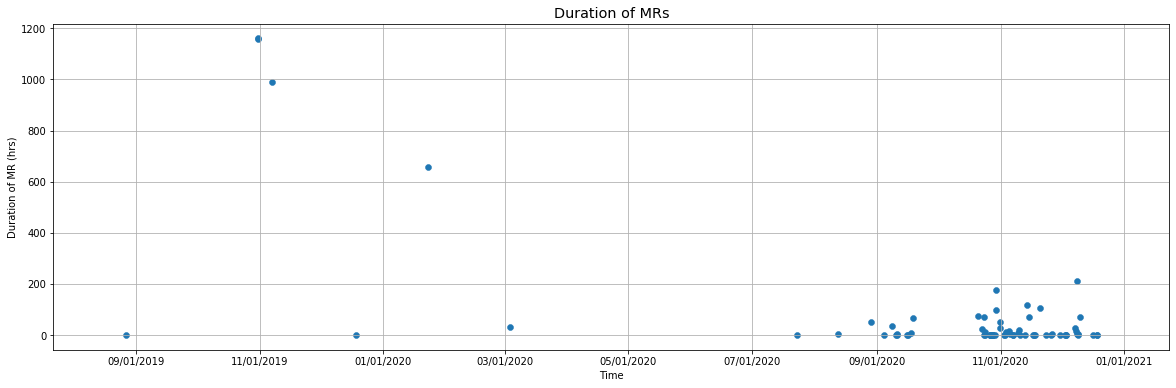

In [35]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.style.use("ggplot")
ax.scatter(dfMRStats['Create Time'], dfMRStats['Duration'], label='Duration (hrs)')
ax.set_xlabel('Time')
ax.set_ylabel('Duration of MR (hrs)')
ax.set_title('Duration of MRs')
ax.xaxis.set_major_formatter(DateFormatter('%m/%d/%Y'))
ax.grid(True)
plt.savefig("duration_mrs_time.png")

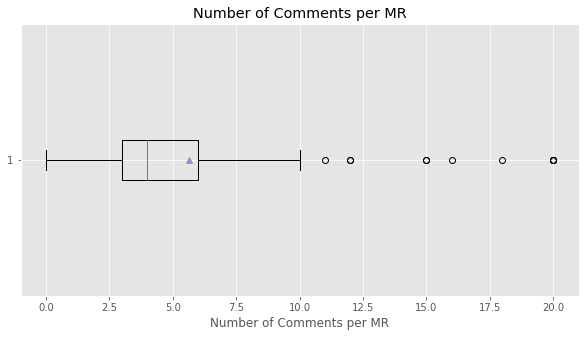

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot(dfMRStats["Num Discussions"], vert=False, showmeans=True)
ax.set_xlabel('Number of Comments per MR')
ax.set_title('Number of Comments per MR')
plt.savefig("num_comments_mrs_spread.png")

# SonarQube Metrics

In [ ]:
# You can find the documentation for the sonarqube python API here: https://python-sonarqube-api.readthedocs.io/

In [42]:
# Auth using the SonarQube API Token
sonar = SonarQubeClient(sonarqube_url="https://sonarcloud.io", token=SONARQUBE_TOKEN)

In [49]:
# Using open source project https://sonarcloud.io/dashboard?id=simgrid_simgrid for demo purposes
component = sonar.measures.get_component_with_specified_measures(component="simgrid_simgrid",
                                                                 branch="master",
                                                                 fields="metrics,periods",
                                                                 metricKeys="coverage")
printJSON(component)

{
  "component": {
    "id": "AWgS5sxSrFADGLK0878z",
    "key": "simgrid_simgrid",
    "name": "SimGrid",
    "qualifier": "TRK",
    "measures": [
      {
        "metric": "coverage",
        "value": "81.7",
        "bestValue": false
      }
    ]
  }
}


In [51]:
coverage = component['component']['measures'][0]['value']
print(coverage)
values['coverage'] = coverage

81.7


In [52]:
component_tree = list(sonar.measures.get_component_tree_with_specified_measures(component="simgrid_simgrid",
                                                                           branch='master',
                                                                           fields='metrics',
                                                                           metricKeys="line_coverage, branch_coverage"))

In [53]:
dfSonarQubeMetrics = collectSonarQubeMetrics(component_tree)

In [54]:
dfSonarQubeMetrics

File Line Coverage  \
0                       src/kernel/resource/Action.cpp          92.6   
1           include/simgrid/kernel/resource/Action.hpp         100.0   
2                                  src/kernel/activity          82.0   
3                     teshsuite/s4u/activity-lifecycle          90.5   
4    teshsuite/s4u/activity-lifecycle/activity-life...          84.2   
..                                                 ...           ...   
947                             src/xbt/xbt_replay.cpp          98.5   
948                                src/xbt/xbt_str.cpp          94.0   
949                           src/xbt/xbt_str_test.cpp         100.0   
950                              src/xbt/xbt_virtu.cpp         100.0   
951                                       src/surf/xml          70.0   

    Branch Coverage  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
..              ...  
947               0  
948               0  
949               0  
950               0  
951               0  

[952 rows x 3 columns]

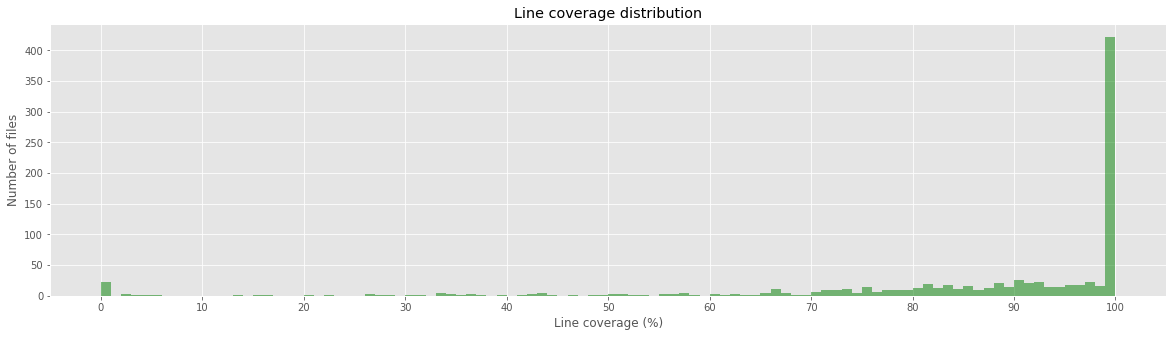

In [83]:
fig, ax = plt.subplots(figsize=(20,5))
plt.style.use("ggplot")
ax.set_xlabel('Line coverage (%)')
ax.set_ylabel('Number of files')
ax.set_title('Line coverage distribution')
coverage = pd.to_numeric(dfSonarQubeMetrics['Line Coverage'], errors='coerce')
hist = ax.hist(coverage.sort_values(), bins=100, alpha=0.5, color='g', label='mag of g')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
plt.savefig("line_coverage.png")

In [98]:
# Extract only the .h files
dfSonarQubeMetricsLineCoverageSmall = dfSonarQubeMetrics.loc[dfSonarQubeMetrics["Line Coverage"].astype(float) < 5]

In [97]:
dfSonarQubeMetricsLineCoverageSmall

File Line Coverage  \
85                           src/mc/remote/AppSide.cpp           3.0   
86                           src/mc/remote/AppSide.hpp           0.0   
95                               src/xbt/backtrace.cpp           5.9   
130                         include/simgrid/chrono.hpp           0.0   
246                                src/surf/cpu_ti.hpp           0.0   
279       include/simgrid/kernel/routing/EmptyZone.hpp           0.0   
348                  include/simgrid/kernel/future.hpp           0.0   
362                             include/simgrid/host.h           0.0   
365                          src/plugins/host_dvfs.cpp           4.9   
457                     src/bindings/lua/lua_utils.cpp           0.0   
491              src/mc/inspect/mc_dwarf_attrnames.cpp           0.0   
492               src/mc/inspect/mc_dwarf_tagnames.cpp           0.0   
498                      src/mc/remote/mc_protocol.cpp           0.0   
627      include/simgrid/kernel/routing/RoutedZone.hpp           0.0   
736                            src/s4u/s4u_Storage.cpp           0.0   
753                src/mc/checker/SimcallInspector.hpp           0.0   
764                            include/simgrid/simix.h           0.0   
788                src/smpi/bindings/smpi_f77_file.cpp           0.0   
804                     src/smpi/bindings/smpi_mpi.cpp           2.2   
831                       src/simix/smx_deployment.cpp           2.9   
839                     teshsuite/simix/stack-overflow           0.0   
840  teshsuite/simix/stack-overflow/stack-overflow.cpp           0.0   
843                    include/simgrid/s4u/Storage.hpp           0.0   
847                           src/surf/storage_n11.hpp           0.0   
849                           src/surf/StorageImpl.hpp           0.0   
874                       include/xbt/system_error.hpp           0.0   
917                            src/mc/VisitedState.cpp           2.6   
918                            src/mc/VisitedState.hpp           0.0   

    Branch Coverage  
85                0  
86                0  
95                0  
130               0  
246               0  
279               0  
348               0  
362               0  
365               0  
457               0  
491               0  
492               0  
498               0  
627               0  
736               0  
753               0  
764               0  
788               0  
804               0  
831               0  
839               0  
840               0  
843               0  
847               0  
849               0  
874               0  
917               0  
918               0

In [99]:
values['low_coverage_table'] = dfSonarQubeMetricsLineCoverageSmall.to_html(escape=False, classes="pure-table pure-table-bordered")

# Generate HTML

In [100]:
report_template = Template(filename='template.html')

In [101]:
print(report_template.render(dictionary=values))
htmlfile = open("dashboard.html", "w")
htmlfile.write(report_template.render(dictionary=values))
htmlfile.close()

<html>
<head>
<title>My Lovely Dashboard</title>
<link rel="stylesheet" href="https://unpkg.com/purecss@2.0.3/build/pure-min.css" integrity="sha384-cg6SkqEOCV1NbJoCu11+bm0NvBRc8IYLRGXkmNrqUBfTjmMYwNKPWBTIKyw9mHNJ" crossorigin="anonymous">
</head>
<body>
<div><h1>My Lovely Dashboard</h1></div>

<div><h2>Gitlab Metrics</h2></div>

<div>
    <div>
    <h3>Duration (hrs) of MRs over time</h3>
    <img src='duration_mrs_time.png'>
    </div>
    <div>
    <div>
    <h3>Number of comments in MRs distribution</h3>
    <img src='num_comments_mrs_spread.png'>
    </div>
</div>
</div>

<div><h2>SonarQube Metrics</h2></div>

<div>
    <center>
        <table class='pure-table'>
            <thead>
                <tr>
                    <th>Overall Coverage</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td><h3>81.7%</h3></td>
                </tr>
            </tbody>
        </table>
    </center>
</div>
<div>
    <h3>Line Coverage<